## *Oxford flower classification (Deep learning)*


In [1]:
import torch                            # Core pytorch for tensor operator
import torch.nn as nn                   # Neural network module (layers, loss_function,..)
import torch.optim as optim             # optimization algorithms (SDG, RMSprop, Adam,...)
import torch.nn.functional as F         # Functional operations (activations, pooling,..)
import torch.utils.data as data         # Dataset handling and batching

import torchvision                                  # Computer vision utilities and pre-trained models
from torchvision import models
from torchvision import transforms                  # Image processing and augmentation
from torchvision import datasets                    # Image processing and augmentation
from torchvision.datasets import CIFAR100           # common CV datasets
from torchvision.models import resnet50             # Pre-trained model supported in PyTorch
from torchvision.models import ViT_B_16_Weights
from torchvision.models import vit_b_16
from torchinfo import summary

f"Torch version: {torch.__version__}", "^",\
f"Torchvision version: {torchvision.__version__}"

"""
A series of helper functions used throughout the course.
If a function gets defined once and could be used over and over, it'll go in here.
"""
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
from pathlib import Path
import requests
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
import time
import sys
import warnings
import random
from PIL import Image 
from datetime import datetime
warnings.filterwarnings("ignore")


## *Diagnostic Code*

In [2]:
import torch.version 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device name: {torch.cuda.get_device_name()}")
print(f"Using device: {device}")
print(f"Cuda version: {torch.version.cuda}")

Device name: Tesla P100-PCIE-16GB
Using device: cuda
Cuda version: 12.1


## *Set up directories*

In [3]:
train_dir = "/kaggle/input/pytorch-challange-flower-dataset/dataset/train"
test_dir = "/kaggle/input/pytorch-challange-flower-dataset/dataset/test"
valid_dir = "/kaggle/input/pytorch-challange-flower-dataset/dataset/valid"


## *Class names*

In [4]:
# Class names from the "cat_to_name" file, now here
flower_names  = {
    "1":"pink primrose",
    "2":"hard-leaved pocket orchid",
    "3":"canterbury bells",
    "4":"sweet pea",
    "5":"english marigold",
    "6":"tiger lily",
    "7":"moon orchid",
    "8":"bird of paradise",
    "9":"monkshood",
    "10":"globe thistle",
    "11":"snapdragon",
    "12":"colt's foot",
    "13":"king protea",
    "14":"spear thistle",
    "15":"yellow iris",
    "16":"globe-flower",
    "17":"purple coneflower",
    "18":"peruvian lily",
    "19":"balloon flower",
    "20":"giant white arum lily",
    "21":"fire lily",
    "22":"pincushion flower",
    "23":"fritillary",
    "24":"red ginger",
    "25":"grape hyacinth",
    "26":"corn poppy",
    "27":"prince of wales feathers",
    "28":"stemless gentian",
    "29":"artichoke",
    "30":"sweet william",
    "31":"carnation",
    "32":"garden phlox",
    "33":"love in the mist",
    "34":"mexican aster",
    "35":"alpine sea holly",
    "36":"ruby-lipped cattleya",
    "37":"cape flower",
    "38":"great masterwort",
    "39":"siam tulip",
    "40":"lenten rose",
    "41":"barbeton daisy",
    "42":"daffodil",
    "43":"sword lily",
    "44":"poinsettia",
    "45":"bolero deep blue",
    "46":"wallflower",
    "47":"marigold",
    "48":"buttercup",
    "49":"oxeye daisy",
    "50":"common dandelion",
    "51":"petunia",
    "52":"wild pansy",
    "53":"primula",
    "54":"sunflower",
    "55":"pelargonium",
    "56":"bishop of llandaff",
    "57":"gaura",
    "58":"geranium",
    "59":"orange dahlia",
    "60":"pink-yellow dahlia",
    "61":"cautleya spicata",
    "62":"japanese anemone",
    "63":"black-eyed susan",
    "64":"silverbush",
    "65":"californian poppy",
    "66":"osteospermum",
    "67":"spring crocus",
    "68":"bearded iris",
    "69":"windflower",
    "70":"tree poppy",
    "71":"gazania",
    "72":"azalea",
    "73":"water lily",
    "74":"rose",
    "75":"thorn apple",
    "76":"morning glory",
    "77":"passion flower",
    "78":"lotus lotus",
    "79":"toad lily",
    "80":"anthurium",
    "81":"frangipani",
    "82":"clematis",
    "83":"hibiscus",
    "84":"columbine",
    "85":"desert-rose",
    "86":"tree mallow",
    "87":"magnolia",
    "88":"cyclamen",
    "89":"watercress",
    "90":"canna lily",
    "91":"hippeastrum",
    "92":"bee balm",
    "93":"ball moss",
    "94":"foxglove",
    "95":"bougainvillea",
    "96":"camellia",
    "97":"mallow",
    "98":"mexican petunia",
    "99":"bromelia",
    "100":"blanket flower",
    "101":"trumpet creeper",
    "102":"blackberry lily"}
    


## *Image transformation*

In [5]:
IMG_SIZE =224

simple_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

simple_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

## *Create Dataset and DataLoader*

In [6]:
NUM_WORKERS = os.cpu_count()
print(f"Maximum number of cpu core available: {NUM_WORKERS}")

def create_dataloaders(train_dir: str, 
                        valid_dir: str, 
                        transform: transforms.Compose, 
                        batch_size: int, 
                        num_workers: int=NUM_WORKERS):
    """
    Creates training and testing DataLoaders.
    
    Takes in a training directory and testing directory path and turns
    them into PyTorch Datasets and then into PyTorch DataLoaders.
    """
    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    valid_data = datasets.ImageFolder(valid_dir, transform=transform)
    
    # Get class names
    class_names = train_data.classes
    
    # Turn images into data loaders
    train_dataloader = data.DataLoader(train_data,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      num_workers=num_workers,
                                      pin_memory=True,)
    
    valid_dataloader = data.DataLoader(valid_data,
                                      batch_size=batch_size,
                                      shuffle=False, # don't need to shuffle test data
                                      num_workers=num_workers,
                                      pin_memory=True,)

    return train_dataloader, valid_dataloader, class_names

train_dataloader, valid_dataloader, classes = create_dataloaders(train_dir=train_dir,
                                                                    valid_dir=valid_dir,
                                                                    transform=simple_transforms,
                                                                    batch_size=NUM_WORKERS)

train_dataloader, valid_dataloader, f"{classes}"

Maximum number of cpu core available: 4


(<torch.utils.data.dataloader.DataLoader at 0x7fc3b3d74b50>,
 "['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']")

## *Image in batch*

In [7]:
image_batch, label_batch = next(iter(train_dataloader))
print(f"Image batch shape: {image_batch.shape} \nLabel batch shape: {label_batch.shape}")

Image batch shape: torch.Size([4, 3, 224, 224]) 
Label batch shape: torch.Size([4])


## Image in tensor

In [8]:
image, label = image_batch[1], label_batch[1]
image, '^', label

(tensor([[[0.7098, 0.6902, 0.6706,  ..., 0.0510, 0.0471, 0.0471],
          [0.6863, 0.6706, 0.6510,  ..., 0.0510, 0.0510, 0.0510],
          [0.6588, 0.6471, 0.6353,  ..., 0.0510, 0.0549, 0.0549],
          ...,
          [0.4902, 0.5176, 0.5647,  ..., 0.2157, 0.1843, 0.1647],
          [0.4980, 0.5333, 0.5804,  ..., 0.1255, 0.1020, 0.0902],
          [0.4941, 0.5255, 0.5725,  ..., 0.0980, 0.0824, 0.0784]],
 
         [[0.0078, 0.0039, 0.0039,  ..., 0.0627, 0.0588, 0.0588],
          [0.0039, 0.0000, 0.0000,  ..., 0.0627, 0.0627, 0.0627],
          [0.0039, 0.0039, 0.0078,  ..., 0.0627, 0.0667, 0.0667],
          ...,
          [0.0039, 0.0039, 0.0078,  ..., 0.2471, 0.2118, 0.1882],
          [0.0000, 0.0000, 0.0000,  ..., 0.1529, 0.1294, 0.1176],
          [0.0078, 0.0078, 0.0000,  ..., 0.1176, 0.1137, 0.1137]],
 
         [[0.0314, 0.0196, 0.0157,  ..., 0.0275, 0.0235, 0.0235],
          [0.0196, 0.0118, 0.0039,  ..., 0.0275, 0.0275, 0.0275],
          [0.0118, 0.0078, 0.0078,  ...,

## Show off single image

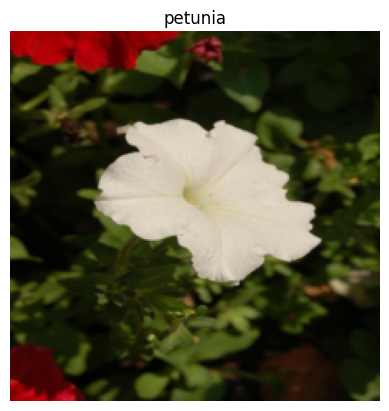

In [9]:
plt.imshow(image.permute(1, 2, 0))
plt.title(flower_names[classes[label]])
plt.axis(False)
plt.show()

## *Show off batch of images*

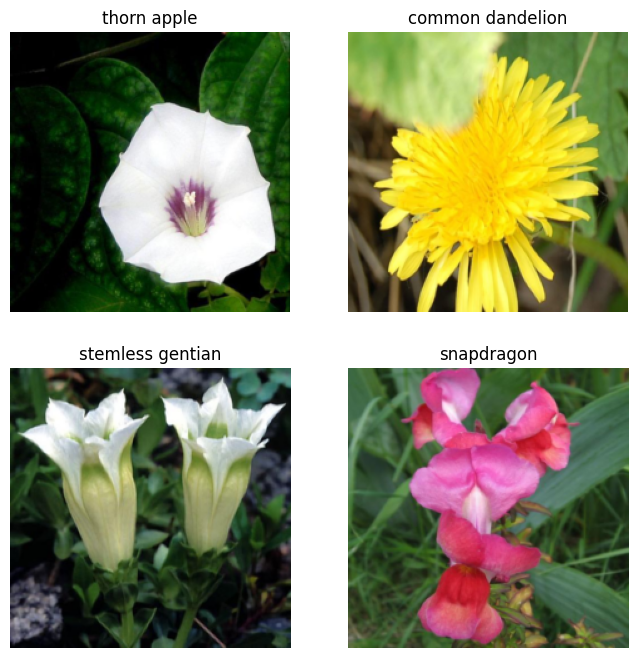

In [10]:
def show_batch(dataloader, batch_size:int=NUM_WORKERS):
    """Displays a batch of images from the dataloader in a grid format."""
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    
    fig, axes = plt.subplots(int(np.sqrt(batch_size)), int(np.sqrt(batch_size)), figsize=(8, 8))
    axes = axes.flatten()

    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img.permute(1, 2, 0))  # Convert (C, H, W) -> (H, W, C)
        ax.set_title(flower_names[classes[label.item()]])  # Convert tensor label to integer
        ax.axis("off")  # Hide axes
    
    plt.show()

show_batch(train_dataloader)

## *Simple CNN*

In [11]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=102):  # 102 flower categories
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # (224x224x3) -> (224x224x32)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)  # Downsample (112x112x32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # (112x112x32) -> (112x112x64)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # (56x56x128)
        self.bn3 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Flatten layer
        self.fc2 = nn.Linear(512, num_classes)   # Output 102 classes

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  
        x = torch.flatten(x, 1)  # Flatten for FC layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # No activation here (CrossEntropyLoss applies softmax)
        return x

# Instantiate model
model = SimpleCNN(num_classes=102)
print(model)


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=102, bias=True)
)


## *Training*

In [12]:
def format_time(seconds: float) -> str:                          # Time formatting helper
    m, s = divmod(int(seconds), 60)
    h, m = divmod(m, 60)
    return f'{h:02d}:{m:02d}:{s:02d}'

def train_step(model: nn.Module,
               dataloader: data.DataLoader,
               loss_fn: nn.Module,
               optimizer: optim.Optimizer,
               device: torch.device,
               epoch: int,
               total_epochs: int,
               start_time: float) -> Tuple[float, float]:
    """"""
    model.train()                                            # Set model to training mode
    train_loss, train_acc = 0, 0                             # Initialize training metrics
    total_steps = len(dataloader)                            # Total batches in epoch
    
    for batch, (X, y) in enumerate(dataloader):              # Training loop
        X, y = X.to(device), y.to(device)                    # Move data to device
        y_pred = model(X)                                    # Forward pass
        loss = loss_fn(y_pred, y)                            # Calculate loss
        train_loss += loss.item()                            # Accumulate loss
        
        optimizer.zero_grad()                                # Clear gradients
        loss.backward()                                      # Backward pass
        optimizer.step()                                     # Update weights
        
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)  # Calculate predictions
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)         # Accumulate accuracy
        
        progress = (batch + 1) / total_steps                 # Calculate progress
        elapsed = time.time() - start_time                   # Time elapsed
        eta = elapsed * (total_steps - (batch + 1)) / max(batch + 1, 1)  # Estimated time remaining
        bar_length = 30                                      # Progress bar length
        filled = int(bar_length * progress)                  # Filled portion of bar
        bar = '=' * filled + '-' * (bar_length - filled)    # Create bar string
        
        metrics = {                                          # Current metrics
            'loss': train_loss/(batch + 1),
            'acc': train_acc/(batch + 1),
            'lr': optimizer.param_groups[0]['lr']
        }
        metrics_str = ' - '.join(f'{k}: {v:.4f}' for k, v in metrics.items())  # Format metrics
        
        status = f'Epoch {epoch+1}/{total_epochs} [{bar}] {progress:.0%} '  # Build status string
        status += f'[{format_time(elapsed)}<{format_time(eta)}] {metrics_str}'
        sys.stdout.write(f'\r{status}')                      # Update progress bar
        sys.stdout.flush()
    
    train_loss = train_loss / total_steps                    # Average training metrics
    train_acc = train_acc / total_steps
    sys.stdout.write('\n')                                   # New line after epoch
    sys.stdout.flush()
    
    return train_loss, train_acc

def test_step(model: nn.Module,
              dataloader: data.DataLoader,
              loss_fn: nn.Module,
              device: torch.device) -> Tuple[float, float]:
    model.eval()                                             # Set model to evaluation mode
    test_loss, test_acc = 0, 0                               # Initialize testing metrics
    
    with torch.no_grad():                                    # Inference mode for testing
        for X, y in dataloader:                              # Testing loop
            X, y = X.to(device), y.to(device)                # Move data to device
            test_pred_logits = model(X)                      # Forward pass
            test_loss += loss_fn(test_pred_logits, y).item() # Accumulate loss
            test_pred_labels = test_pred_logits.argmax(dim=1)  # Calculate predictions
            test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)  # Accumulate accuracy
    
    test_loss = test_loss / len(dataloader)                  # Average testing metrics
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train_model(model: nn.Module,
                train_dataloader: data.DataLoader,
                test_dataloader: data.DataLoader,
                optimizer: optim.Optimizer,
                loss_fn: nn.Module,
                epochs: int,
                device: torch.device,
                seed: int = 16) -> Dict[str, List]:
    torch.manual_seed(seed)                                  # Set seed for reproducibility
    torch.cuda.manual_seed(seed)                             # Set CUDA seed for GPU operations
    
    results = {"train_loss": [],                             # Initialize results dictionary
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    start_time = time.time()                                 # Track total training time
    
    for epoch in range(epochs):                              # Main epoch loop
        train_loss, train_acc = train_step(                  # Perform training step
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
            epoch=epoch,
            total_epochs=epochs,
            start_time=start_time
        )
        
        test_loss, test_acc = test_step(                     # Perform testing step
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device
        )
        
        results["train_loss"].append(train_loss)             # Store results
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    
    return results


## Pre-trained ViT

In [13]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = models.ViT_B_16_Weights.DEFAULT 
pretrained_vit = models.vit_b_16(weights=pretrained_vit_weights).to(device)



Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 210MB/s] 


## *Freeze the base Paramaters*

In [14]:
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False


## *Change the classified head*

In [15]:
# Change the classifier head (set the seeds to ensure same initialization with linear head)
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(classes)).to(device)
pretrained_vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

## *Summarize model*

In [16]:
summary(model=pretrained_vit,
        input_size=(NUM_WORKERS, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=25,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
VisionTransformer (VisionTransformer)                        [4, 3, 224, 224]          [4, 102]                  768                       Partial
├─Conv2d (conv_proj)                                         [4, 3, 224, 224]          [4, 768, 14, 14]          (590,592)                 False
├─Encoder (encoder)                                          [4, 197, 768]             [4, 197, 768]             151,296                   False
│    └─Dropout (dropout)                                     [4, 197, 768]             [4, 197, 768]             --                        --
│    └─Sequential (layers)                                   [4, 197, 768]             [4, 197, 768]             --                        False
│    │    └─EncoderBlock (encoder_layer_0)                   [4, 197, 768]             [4, 197, 768]             (7,087,872)   

## *Pre-trained ViT transform*

In [17]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


## *Setup DataLoader*

In [18]:
train_dataloader_pretrained, \
    test_dataloader_pretrained, \
        class_names = create_dataloaders(train_dir=train_dir,
                                        valid_dir=valid_dir,
                                        transform=pretrained_vit_transforms,
                                        batch_size=NUM_WORKERS) 

train_dataloader_pretrained, \
    test_dataloader_pretrained, \
        f"{class_names}"

(<torch.utils.data.dataloader.DataLoader at 0x7fc3b0233670>,
 "['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']")

## *Training Pre-trained ViT*

In [19]:
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

pretrained_vit_results = train_model(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

Epoch 1/10 [==============================] 100% [00:01:35<00:00:00] loss: 1.1446 - acc: 0.7712 - lr: 0.0010
Epoch 2/10 [==============================] 100% [00:03:15<00:00:00] loss: 0.1980 - acc: 0.9649 - lr: 0.0010
Epoch 3/10 [==============================] 100% [00:04:55<00:00:00] loss: 0.0880 - acc: 0.9846 - lr: 0.0010
Epoch 4/10 [==============================] 100% [00:06:36<00:00:00] loss: 0.0443 - acc: 0.9959 - lr: 0.0010
Epoch 5/10 [==============================] 100% [00:08:16<00:00:00] loss: 0.0245 - acc: 0.9974 - lr: 0.0010
Epoch 6/10 [==============================] 100% [00:09:57<00:00:00] loss: 0.0161 - acc: 0.9983 - lr: 0.0010
Epoch 7/10 [==============================] 100% [00:11:37<00:00:00] loss: 0.0076 - acc: 0.9995 - lr: 0.0010
Epoch 8/10 [==============================] 100% [00:13:17<00:00:00] loss: 0.0057 - acc: 0.9992 - lr: 0.0010
Epoch 9/10 [==============================] 100% [00:14:58<00:00:00] loss: 0.0036 - acc: 0.9997 - lr: 0.0010
Epoch 10/10 [======



##  *Save the model*


In [20]:
def save_model(model: nn.Module,
               target_dir: str = "saved_models",
               model_name: str = None) -> None:

    model_name = model._get_name() if model_name == None else model_name
    timestamp = datetime.now().strftime("%d_%m_%Y")         # Format date as day_month_year
    full_model_name = f"{model_name}_{timestamp}_{torch.cuda.get_device_name()}.pth"       # Combine name with timestamp
    target_dir_path = Path(target_dir)                      # Convert to Path object
    target_dir_path.mkdir(parents=True, exist_ok=True)      # Create directory if needed
    model_save_path = target_dir_path / full_model_name     # Complete file path
    # Save the model
    print(f"[INFO] Saving model to: {model_save_path}")     # Log save operation
    torch.save(obj=model.state_dict(), f=model_save_path)   # Save model state_dict

# Save the model
save_model(model=pretrained_vit)

[INFO] Saving model to: saved_models/VisionTransformer_27_03_2025_Tesla P100-PCIE-16GB.pth


## Inference

In [21]:
# "Lovecrush"

In [ ]:
"Kaggle testing"